# Multivariate time series forecast with Prophet

In this project we will try to forecast temperature for the next  113 days. We will use Prophet algorithm for predicting future temperature. Propphet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. First we will do exploratory data analysis and then we will build our model.

In [34]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
plt.style.use("fivethirtyeight")
import warnings; 
warnings.simplefilter('ignore')
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [2]:
#reading training and test sets
train=pd.read_csv("climate_train.csv")
test=pd.read_csv("climate_test.csv")

####  Exploring trainig set

In [3]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
#shape of training set
train.shape

(1462, 5)

In [5]:
#data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


As we can see our date column is an object so we will transform it into padnas datetime.

### Counting and visualizing missing values

In [6]:
def miss_percentage(df):
    """
    Calculate missing value percentage per dataset features (columns in dataframe).
    :param df: input pandas dataframe with missing values
    :return:   pandas dataframe, index = column names, columns = [missing values percentage, missing count]
    """
    df_missing = df.isnull().sum().reset_index()
    df_missing.columns = ["features", "missing_counts"]
    df_len = df.shape[0]
    df_missing["missing_percentage"] = df_missing["missing_counts"].apply(lambda v: round(v/df_len,2))

    return df_missing.sort_values(by="missing_percentage", ascending=False).set_index(keys="features")


In [7]:
miss_percentage(train)

,missing_counts,missing_percentage
features,,
date,0,0.0
meantemp,0,0.0
humidity,0,0.0
wind_speed,0,0.0
meanpressure,0,0.0


<AxesSubplot:>

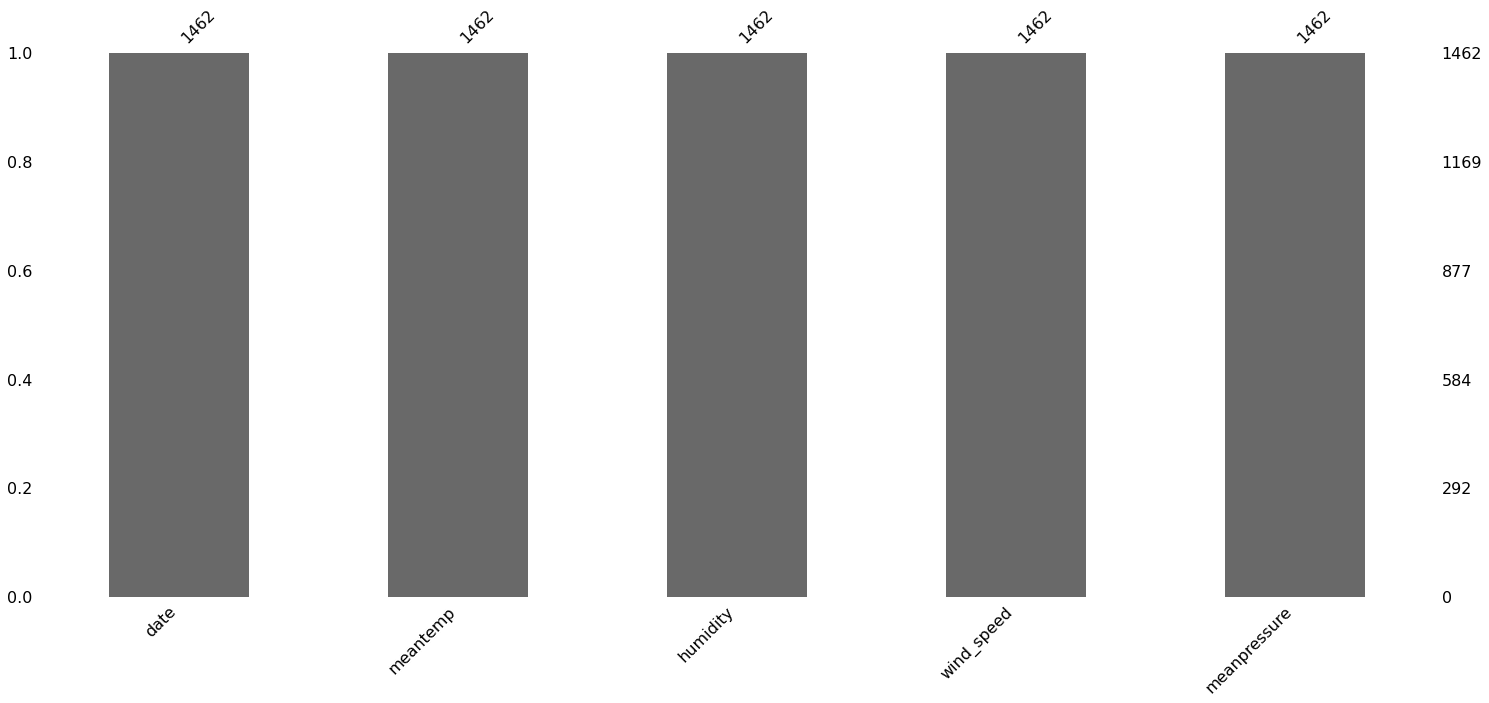

In [12]:
# visualizing missing values
msno.bar(train)

### Exploratory data analysis

In [8]:
train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


From describing table above we can see some outliers in all our columns.

### Visualizing distribution of  numerical coulmns

In [15]:
cols=["meantemp","humidity","wind_speed","meanpressure"]

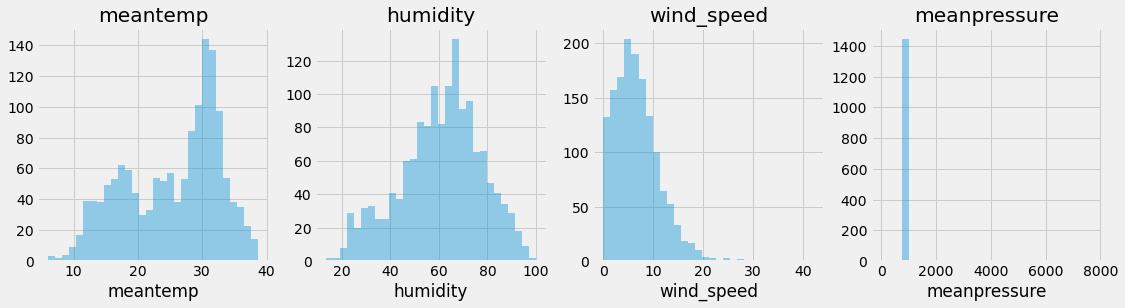

In [30]:
plt.figure(figsize=(17,4))
for i,feature in enumerate(cols):
    plt.subplot(1,4,i+1)
    sns.distplot(train[feature], hist=True, kde=False, label='All values', bins=30)
    plt.title(feature)

From distribution plots we can conclde this:

-  most of tempertures are between 30 and 32 C
- most of humidity are between 65 and 70
- most of wind speed are between 5 and 10 km/h
- most students studies 2-5 hours
- all of our columns are right skewed,except humidity which is nearly normal distributed

### Visualizing outliers

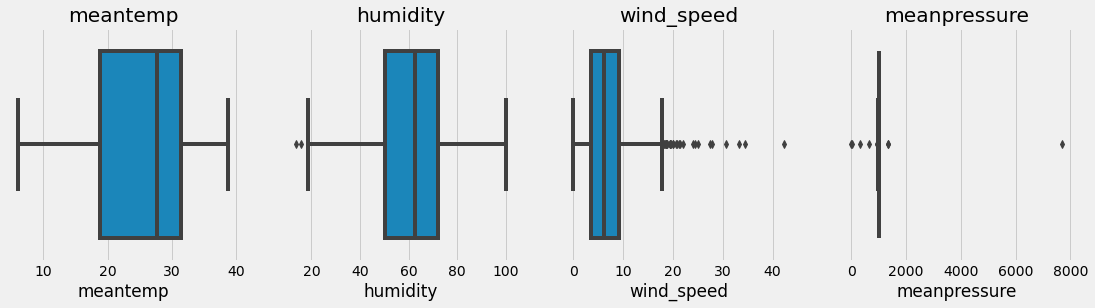

In [35]:
plt.figure(figsize=(17,4))
for i,feature in enumerate(cols):
    plt.subplot(1,4,i+1)
    sns.boxplot(train[feature])
    plt.title(feature)

From box plots above we can conclude this:

- all of our columns,except meantemp have at least one outlier
- wind_speed coulmn has the most outliers
- we will keep all outliers

### Correlation between numerical columns

#### Pearson and Spearman correlation

The size of a correlation coefficient suggests correlation between independent and dependent variable. p-value indicates significance of correlation coefficient (p-value <= 0.05). We will use the following methods to calculate the correlation coefficients:

- Pearson correlation coefficient - strength and direction of the linear relationship between two variables
- Spearman correlation coefficient - Spearman's correlation determines the strength and direction of the monotonic relationship between two variables rather than the strength and direction of the linear relationship between two variables


#### Pearson correlation

<AxesSubplot:>

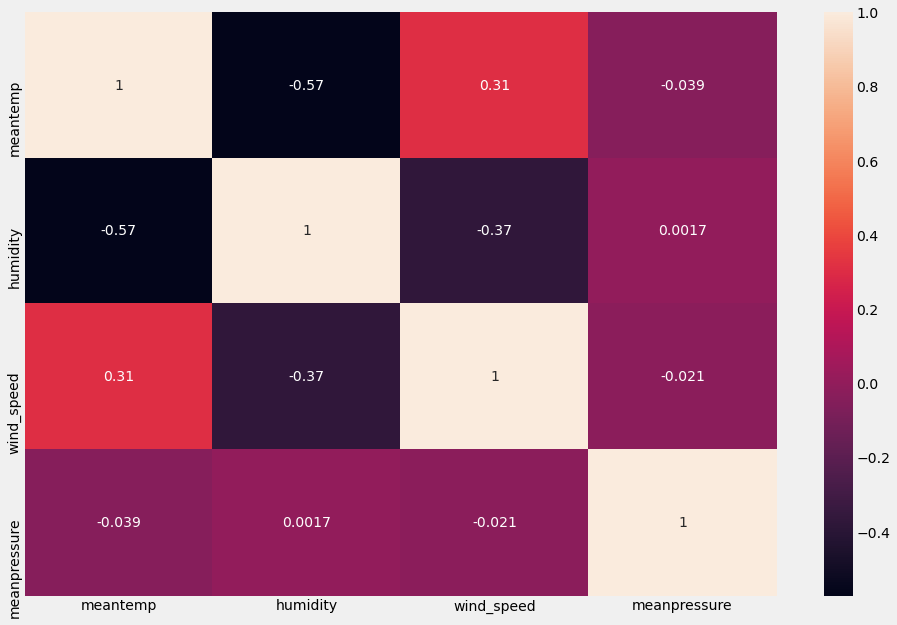

In [38]:
#Pearson correlation
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True)

From heatmap above we can see correlation between our features and target column.

- we have strong negative correlation between humidtiy and meantemp
- we have positive correlation between wind_speed and mean temp
- for better forecasting we will use all of this features and make multivariate time series forecasting

<AxesSubplot:>

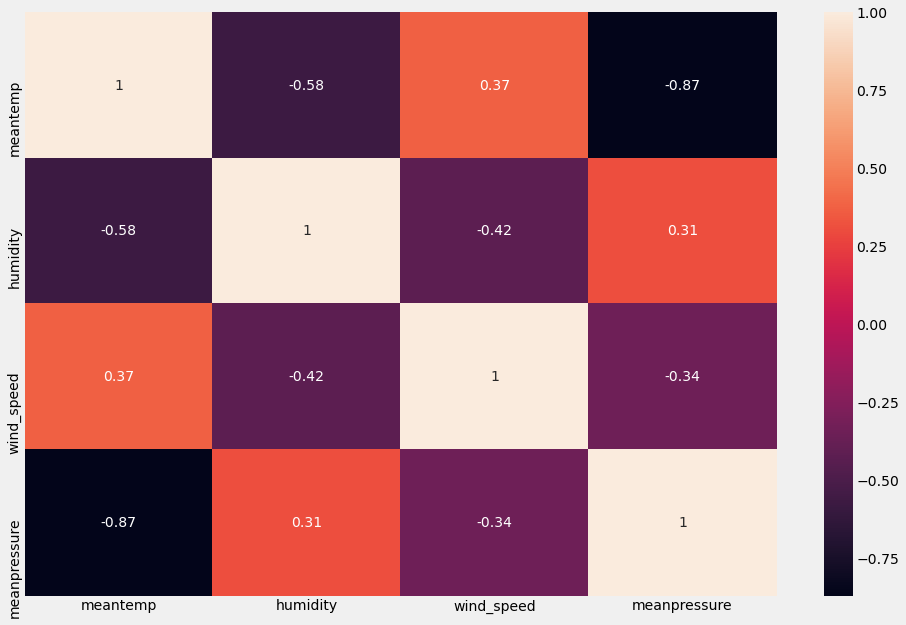

In [40]:
#Spearman correlation
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(method="spearman"),annot=True)

#### Visualizing temperature over time

In [45]:
df=train.copy()

<AxesSubplot:>

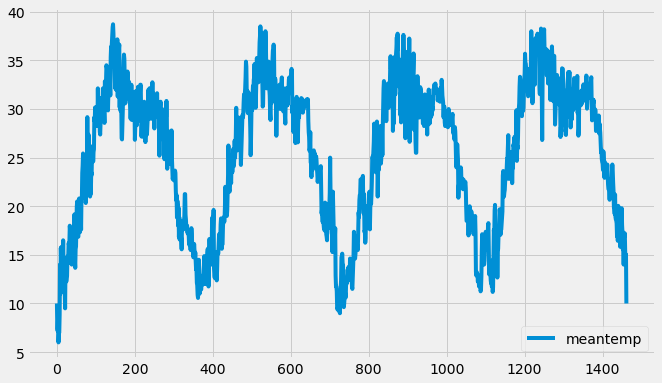

In [46]:
df[["meantemp"]].plot(figsize=(10,6))

As we can see our data is pretty much stationary so there will be no need for transforming our data.

### Preparing data for model

In [47]:
#transforming date column into pandas datetime format
train["date"]=pd.to_datetime(train["date"])

We will need to rename our date column into "ds" and our target column into "y".

In [48]:
#renaming columns
train=train.rename(columns={"date":"ds","meantemp":"y"})

In [49]:
train.head()

,ds,y,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [50]:
#last date of test set
test.tail()

,date,meantemp,humidity,wind_speed,meanpressure
109,2017-04-20,34.500,27.500000,5.562500,998.625000
110,2017-04-21,34.250,39.375000,6.962500,999.875000
111,2017-04-22,32.900,40.900000,8.890000,1001.600000
112,2017-04-23,32.875,27.500000,9.962500,1002.125000
113,2017-04-24,32.000,27.142857,12.157143,1004.142857


### Building multivariate time series model

In [51]:
#importing Prophet 
from fbprophet import Prophet

In [55]:
#setting model
model = Prophet(interval_width=0.95,daily_seasonality=True)

In [56]:
# adding regressor for better accuracy
model.add_regressor("humidity")
model.add_regressor("wind_speed")
model.add_regressor("meanpressure")

In [57]:
#fitting model
model.fit(train)

In [58]:
# Creating future dataframe for 113 days
future = model.make_future_dataframe(periods=113)

In [59]:
future.tail()

,ds
1570,2017-04-20
1571,2017-04-21
1572,2017-04-22
1573,2017-04-23
1574,2017-04-24


In [60]:
#concating data with test set and printing only important features
df=df.append(test)
df = df.rename(columns={"date":"ds","meantemp": "y" })
future_data=df[["ds", "humidity", "wind_speed", "meanpressure"]]

In [61]:
# Making predictions
prediction = model.predict(future_data)

In [62]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1571,2017-04-20,33.652887,30.561585,36.615616
1572,2017-04-21,32.319102,29.201779,35.482634
1573,2017-04-22,32.268125,29.217625,35.438928
1574,2017-04-23,33.895272,30.879208,36.948565
1575,2017-04-24,34.063156,30.833899,37.201012


### Visualizing our model predictions

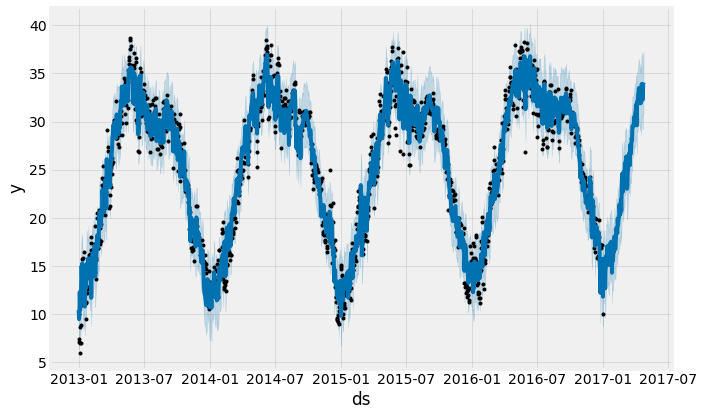

In [63]:
# Plot Our Predictions
model.plot(prediction)
plt.show()

##### Narrative
- A Trending data
- Black dots : the actual data points in our dataset.
- Deep blue line : the predicted forecast/the predicted values
- Light blue line : the boundaries (yhat_lower,yhat_upper)

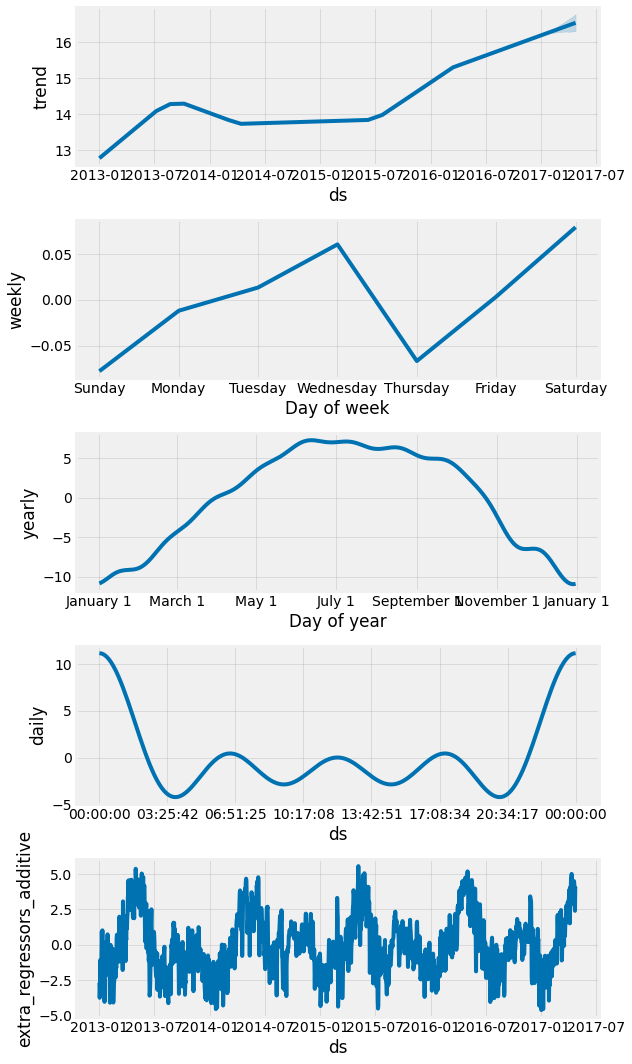

In [64]:
# Visualize each component
model.plot_components(prediction)
plt.show()

From graphs above we can conclude:

- we have up rising trend
- on Saturday are highest temperatures
- from May to September we have highest temperatures

### Cross Validation
- For measuring forecast error by comparing the predicted values with the actual values
- initial:the size of the initial training period
- period : the spacing between cutoff dates
- horizon : the forecast horizon((ds minus cutoff)

By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon



![](cutoff.png)

In [65]:
#importing cross-validation
from fbprophet.diagnostics import cross_validation

In [66]:
future_data.shape

(1576, 4)

In [67]:
#making cross-validated dataframe
cv = cross_validation(model,initial='720 days', period='90 days', horizon = '180 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-12 00:00:00 and 2016-07-05 00:00:00


In [68]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-13,12.966173,10.100958,15.690658,12.250,2015-01-12
1,2015-01-14,12.694217,9.733675,15.393907,12.000,2015-01-12
2,2015-01-15,12.631342,9.791827,15.286904,12.375,2015-01-12
3,2015-01-16,12.923106,10.375489,15.805063,13.000,2015-01-12
4,2015-01-17,13.506624,10.626257,16.097443,13.500,2015-01-12


In [69]:
cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1255,2016-12-28,16.768539,13.510242,20.179151,17.217391,2016-07-05
1256,2016-12-29,14.064529,10.677065,17.412769,15.238095,2016-07-05
1257,2016-12-30,13.947061,10.713376,16.904719,14.095238,2016-07-05
1258,2016-12-31,14.335856,10.967420,17.654420,15.052632,2016-07-05
1259,2017-01-01,12.981730,9.532064,16.476046,10.000000,2016-07-05


### Visualizing model performance

In [72]:
#importing library
from fbprophet.diagnostics import performance_metrics

In [73]:
metrics = performance_metrics(cv)

In [74]:
metrics

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,2.810776,1.676537,1.387146,0.064916,0.050061,0.944444
1,19 days,2.912889,1.706719,1.423870,0.066638,0.050946,0.944444
2,20 days,2.909968,1.705863,1.422303,0.066423,0.050061,0.944444
3,21 days,2.850402,1.688313,1.405291,0.065704,0.048938,0.944444
4,22 days,2.957714,1.719801,1.428965,0.067267,0.049261,0.936508
...,...,...,...,...,...,...,...
158,176 days,25655.095626,160.172081,15.886744,0.619352,0.056851,0.857143
159,177 days,25655.462248,160.173226,15.942222,0.621065,0.057204,0.849206
160,178 days,25655.726261,160.174050,15.974515,0.622484,0.057709,0.833333
161,179 days,25655.933656,160.174697,16.004756,0.623614,0.057204,0.817460


In [75]:
# import library
from fbprophet.plot import plot_cross_validation_metric

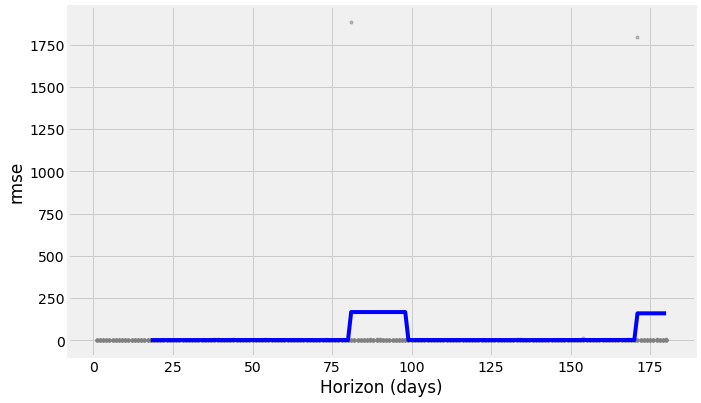

In [76]:
# plotting RMSE
plot_cross_validation_metric(cv,metric='rmse')
plt.show()

We can see that our model did pretty much great work. Between 80 and 100 horizon days we have some higher error.

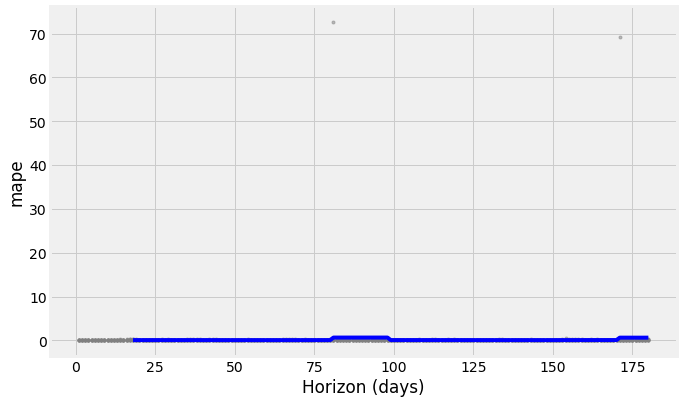

In [77]:
plot_cross_validation_metric(cv,metric='mape')
plt.show()

#### Calculating  Mean Absolute Error

In [82]:
#importing library
from sklearn.metrics import mean_absolute_error

In [83]:
test=test.rename(columns={"meantemp":"y"})

In [84]:
# calculate MAE between expected and predicted values 
y_true = test['y'].values
y_pred = prediction['yhat'][-114:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 2.553


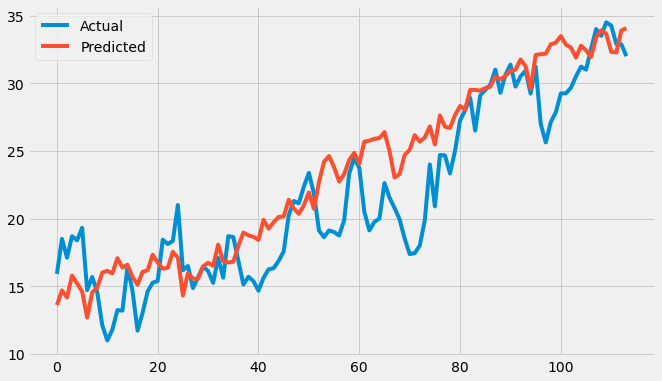

In [81]:
# plot expected vs actual
plt.figure(figsize=(10,6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

WE got 2.55 MAE which is pretty low.

### Hyperparameter tuning

In [85]:
#setting cutoffs
cutoffs = pd.to_datetime(["2015-01-12","2015-07-11","2016-01-07","2016-07-05"])

In [87]:
import itertools
warnings.simplefilter('ignore')
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params,daily_seasonality=True).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days',parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c3e06b2e0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c787417c0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c3d6340d0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c3d819e50>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c2f6d2cd0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c3d6340d0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c2f6ccd00>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5c2efbd070>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPool

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  2.128451
1                     0.001                     0.10  2.058628
2                     0.001                     1.00  2.122899
3                     0.001                    10.00  2.066749
4                     0.010                     0.01  2.215594
5                     0.010                     0.10  2.252690
6                     0.010                     1.00  2.234273
7                     0.010                    10.00  2.232432
8                     0.100                     0.01  2.912521
9                     0.100                     0.10  2.262432
10                    0.100                     1.00  2.255948
11                    0.100                    10.00  2.277620
12                    0.500                     0.01  3.883352
13                    0.500                     0.10  2.099906
14                    0.500                     1.00  2

In [91]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}
